# Tutorial: Absolute Scoring

This cookbook gets you started running evals with absolute scores, and does so on a sample set from the public benchmark [FLASK](https://arxiv.org/pdf/2307.10928) dataset - a collection of 1,740 human-annotated samples from 120 NLP datasets. Evaluators assign scores ranging from 1 to 5 for each annotated skill based on the reference (ground-truth) answer and skill-specific scoring rubrics.
<br>

We evaluate logical robustness (whether the model avoids logical contradictions in its reasoning) and completeness (whether the response provides sufficient explanation) using default and custom-defined metrics respectively, then compare how Selene's scores align with the human labels.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atla-ai/atla-sdk-python/blob/main/cookbooks/Atla_Selene_Absolute_Scoring.ipynb)

## Setup

### Install dependencies

In [19]:
# Install Atla.
!pip install atla --quiet

# Install other dependencies for this notebook.
!pip install asyncio --quiet
!pip install datasets --quiet
!pip install matplotlib --quiet
!pip install nest_asyncio --quiet
!pip install pandas --quiet
!pip install scikit-learn --quiet
!pip install seaborn --quiet

### Set up Atla API key


You can get your Atla API key for free [here](https://www.atla-ai.com/sign-up).

In [20]:
from atla import Atla, AsyncAtla

ATLA_API_KEY = "<your_api_key>" # replace with your own API key

client = Atla(api_key=ATLA_API_KEY)
async_client = AsyncAtla(api_key=ATLA_API_KEY)

## Run an initial example

### Inspect the data

Here's a quick example for evaluating a mathematical question with a reference response.

In [21]:
example_input = "Is -7 a prime number? Explain why or why not."

example_answer = """No, -7 is not a prime number.
Prime numbers are defined as positive integers greater than 1 that have exactly two positive divisors: 1 and themselves.
Since -7 is negative, it's not prime."""

example_ground_truth = """No, -7 is not a prime number.
By definition, prime numbers must satisfy three criteria:
(1) they must be integers, (2) they must be greater than 1, and (3) they must have exactly two positive divisors - 1 and the number itself.
While -7 is an integer, it fails the second criterion because it is negative, not greater than 1. """

### Run the Atla API

Let's try using the Atla API to get a score and feedback from Selene.

We can start off using one of our [default metrics](https://docs.atla-ai.com/build/metrics/default). These metrics cover common evaluation scenarios and are optimized for immediate use.


<br>

We'll try `atla_default_logical_coherence` that evaluates how well-reasoned and internally consistent the response is.

> Certain default metrics require specific fields to be provided. For `atla_default_logical_coherence`, we need to provide:
>
> * `model_input`
> * `model_output`

As we have an example, we can optionally provide `expected_model_output` to calibrate Selene on what a perfect response looks like.

In [22]:
import textwrap

# Let's try evaluating our example using the Atla API

evaluation = client.evaluation.create(
    model_id="atla-selene",
    model_input=example_input,
    model_output=example_answer,
    expected_model_output=example_ground_truth,
    metric_name="atla_default_logical_coherence" # Choose the conciseness metric
).result.evaluation

print("\nScore:", evaluation.score) # Print Selene's score
print("\nCritique:")
print("\n".join(textwrap.wrap(evaluation.critique, width=80))) # Print Selene's critique



Score: 4

Critique:
The response is logically sound and directly addresses the question. It
correctly defines prime numbers and explains why -7 does not fit this definition
due to its negative value. However, it could be improved by explicitly stating
all criteria for a prime number, as seen in the reference answer, to provide a
comprehensive explanation. The current explanation is concise but lacks detail
in the definition of prime numbers, which could lead to slight confusion for
those unfamiliar with the concept.


## Run batch evals

If we want to [test multiple examples](https://docs.atla-ai.com/build/best-practices), we can use Atla's async client to run multiple evaluations in parallel.

### Load our absolute scoring test data

We load test data from the publicly accessible [FLASK](https://arxiv.org/pdf/2307.10928) dataset - a collection of **1,740 human-annotated samples from 120 NLP datasets** - from the [GitHub repo](https://github.com/kaistAI/FLASK).

> Evaluators assign scores ranging from **1 to 5** for each annotated skill based on the reference (ground-truth) answer and skill-specific scoring rubrics.

<br>

For this dataset, we will analyse the following metrics:

1. **Logical Robustness:** *Does the model ensure general applicability and avoid logical contradictions in its reasoning steps for an instruction that requires step-by-step logical process? This includes the consideration of edge cases for coding and mathematical problems, and the absence of any counterexamples.*
    - We can use `atla_default_logical_coherence` for this metric.

2. **Completeness:**  *Does the response provide a sufficient explanation? Comprehensiveness and thoroughness of the response should be considered, which depends on the breadth of topics covered and the level of detail provided within each topic.*
    - We need to define a custom evaluation criteria for this metric.

In [23]:
import pandas as pd

FLASK_dataset = pd.read_json("https://raw.githubusercontent.com/prometheus-eval/prometheus-eval/refs/heads/main/eval/benchmark/data/flask_eval.json")

FLASK_dataset.head()

,idx,response_source,criteria,instruction,human_score,gpt4_score
0,13,bard,Insightfulness,###Task Description:\nAn instruction (might in...,"[5, 5, 5]","[3, 4, 2]"
1,13,bard,Factuality,###Task Description:\nAn instruction (might in...,"[4, 5, 4]","[4, 5, 4]"
2,13,bard,Comprehension,###Task Description:\nAn instruction (might in...,"[4, 5, 5]","[3, 5, 4]"
3,30,bard,Conciseness,###Task Description:\nAn instruction (might in...,"[3, 2, 5]","[2, 3, 2]"
4,30,bard,Commonsense Understanding,###Task Description:\nAn instruction (might in...,"[5, 2, 5]","[3, 2, 2]"


### Process the data

Now, we need to do a bit of preprocessing with [`pandas`](https://pandas.pydata.org/) and [`re`](https://docs.python.org/3/library/re.html).

- The user input, assistant response, and reference response are all contained in `instruction` as a json <- **let's extract these into separate columns**
- `human_score` contains 3 different scores across different annotators <- **let's take an average to compare Selene scores against**

In [24]:
import re

# Apply the extraction to create new columns
def extract_columns(instruction):
    pattern = r"###The instruction to evaluate:(.*?)###Response to evaluate:(.*?)###Reference Answer \(Score 5\):(.*?)###Score Rubrics:"
    matches = re.search(pattern, instruction, re.DOTALL)

    if matches:
        return {
            'user_input': matches.group(1).strip(),
            'assistant_response': matches.group(2).strip(),
            'ground_truth': matches.group(3).strip()
        }
    return None

In [25]:
import numpy as np

# Process the samples annotated for Logical Robustness
logical_df = FLASK_dataset[FLASK_dataset['criteria'] == 'Logical Robustness'].head(25).copy()
logical_df['avg_human_score'] = logical_df['human_score'].apply(np.mean)
extracted = logical_df['instruction'].apply(lambda x: pd.Series(extract_columns(x)))
logical_df[['user_input', 'assistant_response', 'ground_truth']] = extracted
logical_final = logical_df[['idx', 'user_input', 'assistant_response', 'ground_truth', 'avg_human_score']]

# Process the samples annotated for Completeness
completeness_df = FLASK_dataset[FLASK_dataset['criteria'] == 'Completeness'].head(25).copy()
completeness_df['avg_human_score'] = completeness_df['human_score'].apply(np.mean)
extracted = completeness_df['instruction'].apply(lambda x: pd.Series(extract_columns(x)))
completeness_df[['user_input', 'assistant_response', 'ground_truth']] = extracted
completeness_final = completeness_df[['idx', 'user_input', 'assistant_response', 'ground_truth', 'avg_human_score']]

In [26]:
# Here's how the data looks now
logical_final.head()

,idx,user_input,assistant_response,ground_truth,avg_human_score
16,131,You will be given an objective and a set of ba...,The correct sequence of actions to successfull...,step0: sit down at table\nstep1: place down ar...,3.666667
39,15,"""from typing import List def below_zero(operat...",The code you provided is a Python function tha...,""" balance = 0 for op in operations: balance +=...",2.000000
51,3,The count-and-say sequence is the sequence of ...,"Sure, I can do that. Here is the Python code t...",class Solution(object):\n def countAndSay(s...,1.666667
131,62,Complete this code properly.\nCode: deposit de...,"Sure, here is the completed code:\n\n```python...",void function ( int arg0 ) { if ( arg0 >= 0 ) ...,3.333333
173,161,Which of the given formulas of PL is the best ...,The best symbolization of the given sentence i...,We refer to Wikipedia articles on formal logic...,3.666667


### Define our async evaluation function

This function is flexible enough to be used with a generic dataframe.

> Remember, only one of `evaluation_criteria` and `metric_name` can be used at a time.

In [27]:
import asyncio
from typing import Optional

async def evaluate_responses_atla(
    df,
    input_col: str,
    output_col: str,
    evaluation_criteria: Optional[str] = None,
    metric_name: Optional[str] = None,
    context_col: Optional[str] = None,
    ground_truth_col: Optional[str] = None
) -> None:
    """
    Asynchronously evaluate responses using Selene and add results to dataframe.
    """
    if evaluation_criteria and metric_name:
        raise ValueError("Only one of evaluation_criteria or metric_name can be provided")

    async def evaluate_single_row(row):
        try:
            eval_params = {
                "model_id": "atla-selene",
                "model_input": row[input_col],
                "model_output": row[output_col]
            }

            if evaluation_criteria:
                eval_params["evaluation_criteria"] = evaluation_criteria
            if metric_name:
                eval_params["metric_name"] = metric_name
            if context_col and context_col in row:
                eval_params["model_context"] = row[context_col]
            if ground_truth_col and ground_truth_col in row:
                eval_params["expected_model_output"] = row[ground_truth_col]

            result = await async_client.evaluation.create(**eval_params)
            return result.result.evaluation.score, result.result.evaluation.critique
        except Exception as e:
            print(f"Error evaluating row {row.name}: {e}")
            return None, None

    df_copy = df.copy()
    tasks = [evaluate_single_row(row) for _, row in df_copy.iterrows()]
    results = await asyncio.gather(*tasks)

    df_copy['selene_score'] = [int(score) if score is not None else None for score, _ in results]
    df_copy['selene_critique'] = [critique for _, critique in results]

    return df_copy

### Run a default metric

We apply our function to the FLASK dataframe with 'Logical Robustness' scores, using the default `atla_default_logical_coherence` metric.

In [28]:
# Helps us run async code in a Colab notebook.
import nest_asyncio
nest_asyncio.apply()

# Run the function.
logical_evaluated = asyncio.run(evaluate_responses_atla(
    logical_final,
    input_col='user_input',
    output_col='assistant_response',
    ground_truth_col='ground_truth',
    metric_name='atla_default_logical_coherence') # The metric to use
)

### Run custom evaluation criteria

We specify a custom evaluation criteria for 'Completeness' using the same score criteria given to human annotators in the FLASK experiment.

We then apply our function to the FLASK dataframe with 'Completeness' scores, replacing the `metric_name` argument with our custom `evaluation_criteria`.

In [29]:
# Helps us run async code in a Colab notebook.
import nest_asyncio
nest_asyncio.apply()

# Define the completeness evaluation criteria
completeness_eval_criteria = """Does the response provide a sufficient explanation? Comprehensiveness and thoroughness of the response should be considered, which depends on the breadth of
  topics covered and the level of detail provided within each topic.
  Score 1: The response doesn’t include any specifics or examples to support the statements
  made.
  Score 2: The response does not provide sufficient details or supportive examples, requiring
  a major effort to make the response more complete.
  Score 3: It is a decent response, but the breadth and depth of the response are rather limited.
  The details and examples used to substantiate the response may be insufficient.
  Score 4: The response provides detailed explanations, but there is room for enhancement.
  The response could be further improved by including more details and supportive examples.
  Score 5: The response fully provides comprehensive explanations. It delves deep into the
  topic, providing as much detail as possible, and it offers several examples to back up its
  points."""

# Run the function.
completeness_evaluated = asyncio.run(evaluate_responses_atla(
    completeness_final,
    input_col='user_input',
    output_col='assistant_response',
    ground_truth_col='ground_truth',
    evaluation_criteria=completeness_eval_criteria) # Custom evaluation criteria

  )

### Inspect results

Let's see how well Selene aligned with the human grades!

We look at two analyses:

1. **Pearson's Correlation**: This simply tells us how well Selene's score align with the human scores.

- You'll want this to be as high as possible, but even human disagree amongst themselves (human annotator agreement typically hovers around 0.6). You can use the following as a rough guide:

  - **High Degree:** Values between 0.50 and 1 suggest a strong correlation.

  - **Moderate Degree:** Values between 0.30 and 0.49 indicate a moderate correlation.

  - **Low Degree:** Values below 0.29 are considered a weak correlation.

2. **Selene vs. Human Score Plot**: This gives us a detailed visual into how Selene's integer scores compare to the average human scores across the scoring range.


- You'll want to see most points clustering near or on the diagonal line, which would indicate strong alignment.

#### Logical Robustness

In [37]:
correlation = logical_evaluated['avg_human_score'].corr(logical_evaluated['selene_score'])
print(f"Pearson correlation: {correlation:.3f}")

Pearson correlation: 0.713


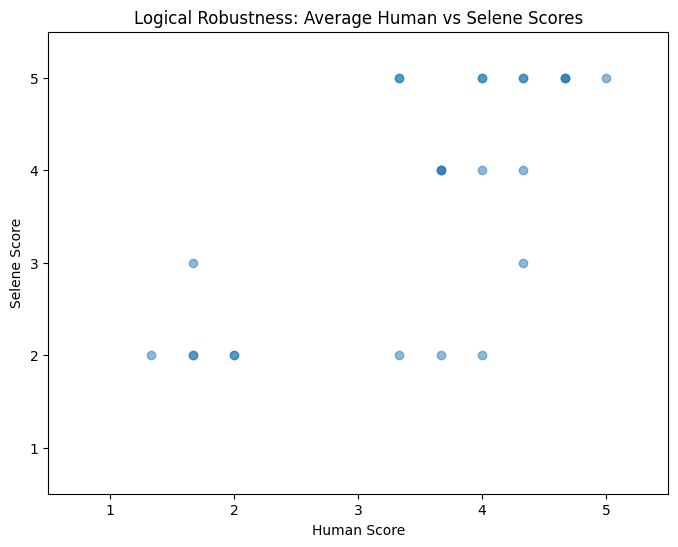

In [34]:
from matplotlib import pyplot as plt

# Distribution plot of human vs. Selene-Mini scores

plt.figure(figsize=(8, 6))
plt.scatter(logical_evaluated['avg_human_score'],
        logical_evaluated['selene_score'],
        alpha=0.5)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.title('Logical Robustness: Average Human vs Selene Scores')
plt.xlabel('Human Score')
plt.ylabel('Selene Score')
plt.show()

Here, it seems we have better alignment at the higher scores (4-5), but more variance in the middle range (3-4) where there aren't many human scores.

#### Completeness

In [38]:
np.corrcoef(completeness_evaluated['avg_human_score'], completeness_evaluated['selene_score'])
print(f"Pearson correlation: {correlation:.3f}")

Pearson correlation: 0.713


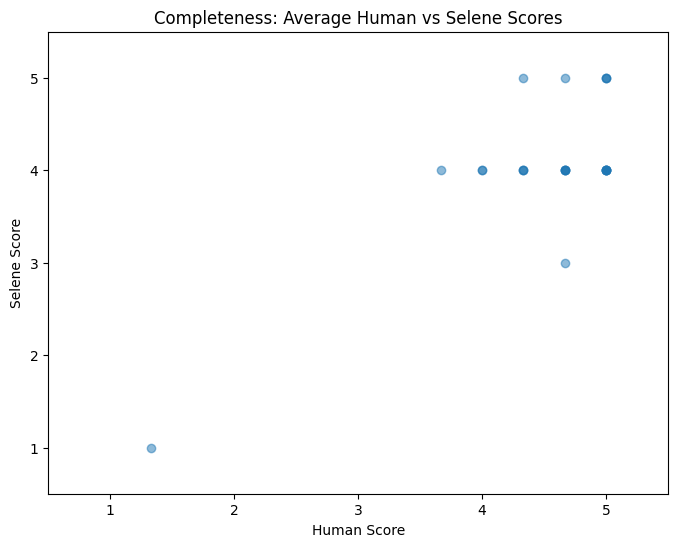

In [35]:
from matplotlib import pyplot as plt

# Distribution plot of human vs. Selene-Mini scores

plt.figure(figsize=(8, 6))
plt.scatter(completeness_evaluated['avg_human_score'],
        completeness_evaluated['selene_score'],
        alpha=0.5)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.title('Completeness: Average Human vs Selene Scores')
plt.xlabel('Human Score')
plt.ylabel('Selene Score')
plt.show()

Here, we can see that the majority of our test set (n=25) was concentrated around the upper end of the scoring range. This plot suggests that we might also want to include test samples that score lower on 'Completeness' to ensure our new eval metric is well-calibrated across the full scoring range.

### Conclusions

As we can see from the experiment above, Selene is exceptionally capable out of the box on standard benchmarks.

With the Atla [Eval Copilot (beta)](https://docs.atla-ai.com/build/usage/eval-copilot), you can fine-tune eval prompts for your specific use cases on your own data to achieve even better results!

[Sign up here](https://www.atla-ai.com/sign-up) to get access right away.
Join our [Discord](https://discord.gg/qFCMgkGwUK) or [email us](mailto:support@atla-ai.com) if we can support you in any way on your eval journey.